# Tensorflow in Practice: Course 1 - Week 4

* In this week we will try to fit a conv net on real world data.
* The data which I have chosen is to classify two types of locomotives on Indian railways. First one is [wap7](https://en.wikipedia.org/wiki/Indian_locomotive_class_WAP-7) and the other one is [wap4](https://en.wikipedia.org/wiki/Indian_locomotive_class_WAP-4)
* Lets quickly see how they look like

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
%matplotlib inline

images_directory = "C:\\DataScience\\Github\\JupyterNotebooks\\computer_vision_railway"

## WAP4

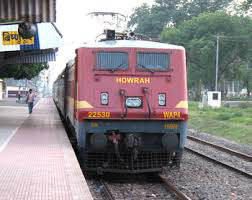

In [6]:
wap4_img = Image.open(os.path.join(images_directory, "train", "wap4", "00000014.jpg"))
wap4_img

## WAP7

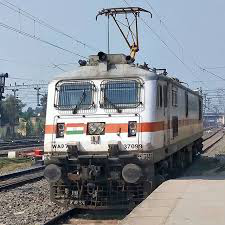

In [7]:
wap7_img = Image.open(os.path.join(images_directory, "train", "wap7", "00000017.jpg"))
wap7_img

* WAP4 and WAP7 locomotives are predominantly red and white colored respectively apart from a few exceptions.
* Their bodies are slightly different in design.
* WAP7s are typically have a single red strip in the middle. Most WAP4s have a yellow strip in the middle although there can be exceptions.

### Vid 1

* ImageGenerator is a class in tensorflow which allows you to load DL data from directories.
* Given a dir1 with dir2 and dir3 sub-dirs. Assume 'dir2' and 'dir3' are the actual labels of your binary DL classifier. Then ImageGenerator will automatically load the data for you even if the images inside dir2 and dir3 dont have labels in their names.
* **keras.preprocessing.image** module contains **image-preprocessing helper tools**
* In this module the class **ImageDataGenerator** lets you quickly setup Python generators **that can automatically turn image files on disk into batches of preprocessed tensors.**

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# rescale param rescales all images by the param i.e. by 1/255
idgen_object_train = ImageDataGenerator(rescale=1./255)
idgen_object_valid = ImageDataGenerator(rescale=1./255)

train_data_generator = idgen_object_train.flow_from_directory(\
    os.path.join(images_directory, "train"),\
    target_size = (150, 150),\
    batch_size = 10,\
    class_mode = 'binary')

valid_data_generator = idgen_object_train.flow_from_directory(\
    os.path.join(images_directory, "test"),\
    target_size = (150, 150),\
    batch_size = 11,\
    class_mode = 'binary')

Found 110 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [9]:
type(train_data_generator)

keras_preprocessing.image.directory_iterator.DirectoryIterator

* A generator is a python object that gives us 1 element in an iterable sequence at a time
* Here this generator which we have formed will give us **batch_size** number of images of size 150 x 150 at a time from train and test directories respectively along with their labels
* Lets test this

In [10]:
for data_batch, labels_batch in train_data_generator:
    batch_1_images = data_batch
    batch_1_labels = labels_batch
    print(f'Data batch shape is {data_batch.shape}')
    print(f'labels_batch shape is {labels_batch.shape}')
    break

Data batch shape is (10, 150, 150, 3)
labels_batch shape is (10,)


### Target=1 is WAP7 or WAP4?

* We can get that information from this step here
* We plot the first image of the 1st batch acquired using the generator
* And then print the corresponding label
* WAP7 is target=1 and WAP4 is target=0

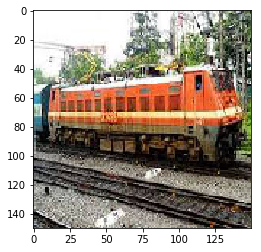

In [38]:
plt.imshow(batch_1_images[0])

In [12]:
batch_1_labels[0]

0.0

* As we can see (20, 150, 150, 3) indicates 20 images of 150 x 150 and 3 channels - as we expected.
* labels are also 20.

### Important note on IDG

1. Intuitively IDG is an abstract class created by combining multiple functions like resizing, creating batch, labelling data etc.. The class, its methods and their arguements can only be understood well with more practice. There is no magic by which you can remember it in the first go.

2. IDG object can produce batch **endlessly**. This is a very important point as how can then we declare that an epoch is over if the data will never be over? We will see how to do this ahead.

## Fitting a conv net to the imported data

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(56, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 56)                4644920   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [41]:
class myCallBack(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('val_acc') > 0.95:
            self.model.stop_training = True

model.compile(loss='binary_crossentropy',\
    optimizer=tf.optimizers.RMSprop(lr=1e-4),\
    metrics=['acc'])

### model.fit_generator()

* To train a model using an IDG, we cannot use the fit method.
* We instead call a fit_generator() method on the model.
* Arguements:
    1. IDG that will yeild batches of targets and inputs indefinitely
    2. steps_per_epoch: Since the generator produces image from the folder **endlessly**, this arguement lets us define a speicifc number of yields after which we end 1 epoch. Usually this is # images / batch_size. In our case we have 110 images in train and 22 in test so we will take steps_per_epoch of 10 and 11 respectively.
    3. validation_data (optional): Can be IDG or tuple of numpy arrays. If IDG then arguement similar to **steps_per_epoch** above named **validation_steps** should be assigned below this

In [42]:
history = model.fit_generator(\
                             train_data_generator,\
                             steps_per_epoch=10,\
                             epochs=30,\
                             validation_data=valid_data_generator,\
                             validation_steps=2,
                             callbacks=[myCallBack()])

Epoch 1/30
10/10 [==============================] - 4s 391ms/step - loss: 0.9467 - acc: 0.4000 - val_loss: 0.7034 - val_acc: 0.5000
Epoch 2/30
10/10 [==============================] - 4s 384ms/step - loss: 0.6937 - acc: 0.5500 - val_loss: 0.6848 - val_acc: 0.5000
Epoch 3/30
10/10 [==============================] - 4s 384ms/step - loss: 0.6732 - acc: 0.5700 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 4/30
10/10 [==============================] - 4s 430ms/step - loss: 0.6621 - acc: 0.6100 - val_loss: 0.6362 - val_acc: 0.8636
Epoch 5/30
10/10 [==============================] - 6s 567ms/step - loss: 0.6350 - acc: 0.6100 - val_loss: 0.6165 - val_acc: 0.5909
Epoch 6/30
10/10 [==============================] - 6s 641ms/step - loss: 0.6003 - acc: 0.6800 - val_loss: 0.6370 - val_acc: 0.5000
Epoch 7/30
10/10 [==============================] - 6s 574ms/step - loss: 0.5847 - acc: 0.7800 - val_loss: 0.5379 - val_acc: 0.8636
Epoch 8/30
10/10 [==============================] - 7s 715ms/step - loss: 0.

### Plotting training and validation metrics

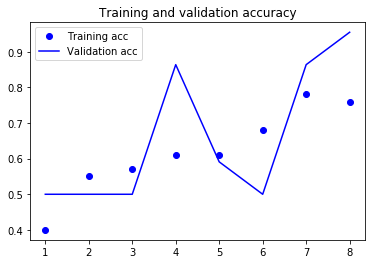

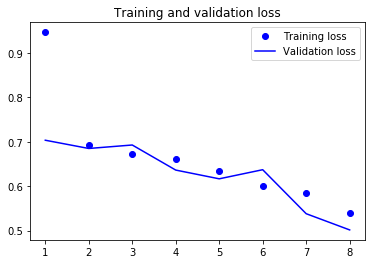

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

* We can see that training and validation loss is going almost together except for a few spikes
* The validation set only has 22 images right now.
* We can try to see if these results hold adding more to the validation data
* Lets try to predict a fresh image we will download from the internet

### Testing the model on unseen images downloaded from internet

* I have downloaded a few images and saved them in **./downloaded_images/wap4** and **./downloaded_images/wap7** directories
* Lets import an image, resize to (150 x 150), convert it into an array, reshape it to (150, 150, 1) and then try to predict whether it is a WAP4 or a WAP7

In [44]:
from keras.preprocessing import image

im1 = image.load_img(os.path.join(images_directory, "downloaded_unseen", "wap4", "12022012126.jpg"),\
                     target_size = (150, 150))
im1_array = image.img_to_array(im1)

Using TensorFlow backend.


(150, 150, 3)

In [45]:
im1_array = np.expand_dims(im1_array, axis=0)

In [46]:
im1_array.shape

(1, 150, 150, 3)

This image is of a WAP4


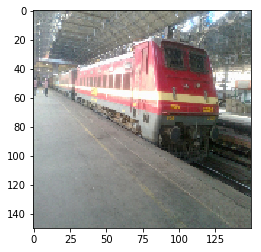

In [47]:
im1_vstack = np.vstack([im1_array])
classes = model.predict(im1_vstack)
if classes[0] > 0.5:
    plt.imshow(im1)
    print("This image is of a WAP7")
else:
    plt.imshow(im1)
    print("This image is of a WAP4")

* Perfecto!

## Importance of thoroughly inspecting your model and noting where it is going wrong

* It is very important to thoroughly inspect your model and getting a sense of why it is making a mistake.
* To do that we will run the model through very different and confusing images and then see the results.
* For example refer to the image below. Our model **wrongly** classifies it as WAP7

PREDICTION: WAP 7
This is a WAP4 wrongly predicted as WAP7 by our model


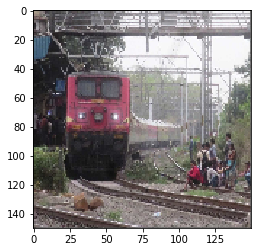

In [52]:
loco_dir= "wap4"
im1 = image.load_img(os.path.join(images_directory, "downloaded_unseen", loco_dir, "5014A.jpg"),\
                     target_size = (150, 150))
im1_array = image.img_to_array(im1)
im1_array = np.expand_dims(im1_array, axis=0)
im1_vstack = np.vstack([im1_array])
classes = model.predict(im1_vstack)
if (classes[0] > 0.5) & (loco_dir=="wap4"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 7\nThis is a WAP4 wrongly predicted as WAP7 by our model")
elif (classes[0] > 0.5) & (loco_dir=="wap7"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 7\nThis is a WAP7 correctly predicted")
elif (classes[0] <= 0.5) & (loco_dir=="wap7"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 4\nThis is a WAP7 wrongly predicted as WAP4 by our model")
elif (classes[0] <= 0.5) & (loco_dir=="wap4"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 4\nThis is a WAP4 correctly predicted")

* So we can see above, the image is of a WAP4 but the model is predicting it to be a WAP7
* Perhaps whats putting off the model is that its not a tight crop of wap4 and there are a lot of poeple sitting it in with other things such as railtracks and electric caternaries.
* Lets try cropping it and then feeding it to the model.

PREDICTION: WAP 4
This is a WAP4 correctly predicted


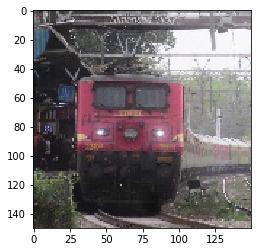

In [53]:
loco_dir= "wap4"
im1 = image.load_img(os.path.join(images_directory, "downloaded_unseen", loco_dir, "5014A_cropped.jpg"),\
                     target_size = (150, 150))
im1_array = image.img_to_array(im1)
im1_array = np.expand_dims(im1_array, axis=0)
im1_vstack = np.vstack([im1_array])
classes = model.predict(im1_vstack)
if (classes[0] > 0.5) & (loco_dir=="wap4"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 7\nThis is a WAP4 wrongly predicted as WAP7 by our model")
elif (classes[0] > 0.5) & (loco_dir=="wap7"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 7\nThis is a WAP7 correctly predicted")
elif (classes[0] <= 0.5) & (loco_dir=="wap7"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 4\nThis is a WAP7 wrongly predicted as WAP4 by our model")
elif (classes[0] <= 0.5) & (loco_dir=="wap4"):
    plt.imshow(im1)
    print(f"PREDICTION: WAP 4\nThis is a WAP4 correctly predicted")

* We see that the model correctly predicted it as a WAP4 this time around.
* So **QUALITY OF COMPUTER VISION DATA** is an altogether different (AND NECESSARY) subject to be studied.
* Lets try some more images

PREDICTION: WAP 7
This is a WAP7 correctly predicted


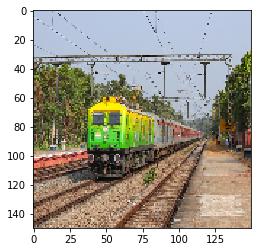

In [54]:
def predict_local(loco_type, image_name):
    loco_dir = loco_type
    im1 = image.load_img(os.path.join(images_directory, "downloaded_unseen", loco_dir, image_name),\
                         target_size = (150, 150))
    im1_array = image.img_to_array(im1)
    im1_array = np.expand_dims(im1_array, axis=0)
    im1_vstack = np.vstack([im1_array])
    classes = model.predict(im1_vstack)
    if (classes[0] > 0.5) & (loco_dir=="wap4"):
        plt.imshow(im1)
        print(f"PREDICTION: WAP 7\nThis is a WAP4 wrongly predicted as WAP7 by our model")
    elif (classes[0] > 0.5) & (loco_dir=="wap7"):
        plt.imshow(im1)
        print(f"PREDICTION: WAP 7\nThis is a WAP7 correctly predicted")
    elif (classes[0] <= 0.5) & (loco_dir=="wap7"):
        plt.imshow(im1)
        print(f"PREDICTION: WAP 4\nThis is a WAP7 wrongly predicted as WAP4 by our model")
    elif (classes[0] <= 0.5) & (loco_dir=="wap4"):
        plt.imshow(im1)
        print(f"PREDICTION: WAP 4\nThis is a WAP4 correctly predicted")
        
predict_local("wap7", "duronto_p7.jpg")

* Thats excellent. Our model was able to predict it as a WAP7 despite its color being a green and yellow duronto special livery

### Vid 5